In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from qiskit import IBMQ, BasicAer
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, ADAM

from data_provider import load_titanic_pd
from utils import record_test_result_for_kaggle


provider = IBMQ.load_account()


In [2]:
np.random.seed(123123)

train_file = "train.csv"
test_file = "test.csv"

df_train, y_train, df_test = load_titanic_pd(train_file, test_file)

# model
print("-----\nFull features:")
model = RandomForestClassifier()
model.fit(df_train, y_train)
# Train score
print("Final train score: %f" % model.score(df_train, y_train))
# F1 score
print("Final F1 score: %f" % f1_score(y_train, model.predict(df_train)))



/Users/kyoma/Documents/Course/quantum/qc_group_project/data_provider.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/Users/kyoma/.local/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/Users/kyoma/Documents/Course/quantum/qc_group_project/data_provider.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value


     Survived  Pclass Sex Age  SibSp  Parch     Fare Embarked
0           0       3   0  22      1      0   7.2500        0
1           1       1   1  38      1      0  71.2833        1
2           1       3   1  26      0      0   7.9250        0
3           1       1   1  35      1      0  53.1000        0
4           0       3   0  35      0      0   8.0500        0
..        ...     ...  ..  ..    ...    ...      ...      ...
886         0       2   0  27      0      0  13.0000        0
887         1       1   1  19      0      0  30.0000        0
888         0       3   1  30      1      2  23.4500        0
889         1       1   0  26      0      0  30.0000        1
890         0       3   0  32      0      0   7.7500        2

[891 rows x 8 columns]
-----
Full features:
Final train score: 0.979798
Final F1 score: 0.973373


/Users/kyoma/Documents/Course/quantum/qc_group_project/data_provider.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value


In [3]:
col_num = 2
mvp_col = df_train.columns[sorted(range(len(model.feature_importances_)),
                                  key=lambda x: model.feature_importances_[x],
                                  reverse=True)[:col_num]].tolist()

print("Selected features: %s" % ",".join(mvp_col))



Selected features: Fare,Age


In [4]:
df_train_q = df_train[mvp_col].values
df_test_q = df_test[mvp_col].values

# Choose balance 50 sample
# 25 pos, 25 neg

np.random.seed(777)

pos_sample = 100
neg_sample = 100

y_train = np.array(y_train)
pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]

print("Postive sample num: %d" % len(pos_label))
print("Negative sample num: %d" % len(neg_label))

Postive sample num: 342
Negative sample num: 549


In [5]:
# Construct dict to feed QSVM
training_input = {
    0: df_train_q[chosen_pos_label_idx],
    1: df_train_q[chosen_neg_label_idx]
}

test_input = df_test_q

###### data prepared
print("data prepared.")

data prepared.


In [18]:
df_kyo = df_train[mvp_col]
#df_kyo = df_train[["Age"]]

In [19]:
print(type(df_kyo["Age"][0]))

<class 'float'>


In [20]:
data = []

for col_name in df_kyo.columns:
    num_cat = len(np.unique(df_kyo[col_name]))
    num_bit = int(np.ceil(np.log2(num_cat)))
    
    print(num_cat, num_bit)
    
    # Padding to x3 
    if num_bit % 3 != 0:
        num_bit = num_bit + (3 - (num_bit % 3))
        
        
    num_qubit = num_bit // 3

    features = []
    for size in df_kyo[col_name]:
        size = int(size)
        # Get last num_bit digit and reverse
        # 11 --> 001  | 011 --> 110 | 100
        all_b_st = f"{size:010b}"[-num_bit:][::-1]

        var_list = []
        for i in range(num_qubit):
            b_st = all_b_st[i * 3: (i+1) * 3]
            
            # b_st = b_1, b_2, b_3 = \sqrt{3}r_x, \sqrt{3}r_y, \sqrt{3}r_z

            if b_st[0] == '1':
                theta = np.arccos(1/np.sqrt(3))
            else:
                theta = np.arccos(-1/np.sqrt(3))

            if b_st[1] == '1' and b_st[2] == '1':
                varphi = np.pi / 4

            if b_st[1] == '1' and b_st[2] == '0':
                varphi = 3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '0':
                varphi = -3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '1':
                varphi = -np.pi / 4

            var_list += [theta, varphi]

        features.append(var_list)
#         print(size, var_list)
    data.append(np.array(features))
    
data = np.concatenate(data, axis=1)

248 8
88 7


In [21]:
# Show ordinal data vs encoded
df_kyo.iloc[:5],data[:5]

(      Fare Age
 0   7.2500  22
 1  71.2833  38
 2   7.9250  26
 3  53.1000  35
 4   8.0500  35,
 array([[ 0.95531662,  0.78539816,  2.18627604, -2.35619449,  2.18627604,
         -2.35619449,  2.18627604,  0.78539816,  2.18627604,  2.35619449,
          2.18627604, -2.35619449],
        [ 0.95531662,  0.78539816,  2.18627604, -2.35619449,  0.95531662,
         -2.35619449,  2.18627604,  0.78539816,  2.18627604, -0.78539816,
          2.18627604, -2.35619449],
        [ 0.95531662,  0.78539816,  2.18627604, -2.35619449,  2.18627604,
         -2.35619449,  2.18627604,  2.35619449,  0.95531662,  2.35619449,
          2.18627604, -2.35619449],
        [ 0.95531662, -0.78539816,  2.18627604,  0.78539816,  2.18627604,
         -2.35619449,  0.95531662,  2.35619449,  2.18627604, -0.78539816,
          2.18627604, -2.35619449],
        [ 2.18627604, -2.35619449,  0.95531662, -2.35619449,  2.18627604,
         -2.35619449,  0.95531662,  2.35619449,  2.18627604, -0.78539816,
          2.1862760

In [22]:
type(y_train)

numpy.ndarray

In [23]:
# Features for encoding

np.random.seed(123123)

df_train_encode, df_test_encode, y_train, y_test = train_test_split(data, y_train, test_size=0.2)

In [24]:
# Construct dict to feed QSVM

# Choose balance 50 sample

np.random.seed(777)

pos_sample = 60
neg_sample = 60

pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]


training_input = {
    0: df_train_encode[chosen_neg_label_idx],
    1: df_train_encode[chosen_pos_label_idx]
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}



In [26]:
def double(x):
    return np.concatenate([x, x], axis=0)

In [27]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

<ipython-input-28-b0d6024b795b>:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  var_form = variational_forms.RYRZ(data.shape[1] // 2)


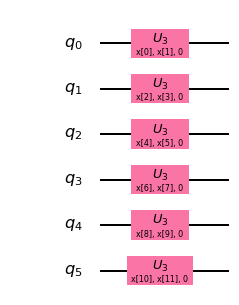

In [28]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [29]:
training_input[1].shape

(534, 12)

In [31]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [32]:

seed = 25252

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


<ipython-input-32-ec25b01d06bf>:7: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)
2020-07-08 19:05:30,002:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 25252, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=25252, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-08 19:05:30,003:qiski

2020-07-08 19:22:33,564:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6875450908306127
2020-07-08 19:22:58,392:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6793432780499412
2020-07-08 19:23:23,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6819560251589475
2020-07-08 19:23:46,350:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6793432780499412
2020-07-08 19:24:10,422:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6846883677840226
2020-07-08 19:24:36,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6793432780499412
2020-07-08 19:25:02,917:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6893950296175039
2020-07-08 19:25:29,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6793432780499412
2020-07-08 19:25:54,324:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch

In [33]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-08 19:50:11,986:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.5912921348314607, 0.5125628140703518)

In [ ]:
###### building quantum dude
seed = 10598
# seed = 1024
var_form = variational_forms.RYRZ(2)
feature_map = ZZFeatureMap(feature_dimension=len(mvp_col), reps=2, entanglement='linear')
qsvm = VQC(ADAM(100), feature_map, var_form, training_input)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, optimization_level=3)
result = qsvm.run(quantum_instance)

y_pred = qsvm.predict(df_train_q)[1]
print("Final train acc: %f\nFinal train F1:%f" % (np.mean(y_pred == y_train), f1_score(y_pred, y_train)))

y_pred = qsvm.predict(df_test_q)[1]
# print(y_pred)

record_test_result_for_kaggle(y_pred, submission_file="quantum_submission.csv")

In [36]:
y_pred = qsvm_encode.predict(df_train_encode)[1]
# print(y_pred)

record_test_result_for_kaggle(y_pred, submission_file="quantum_submission.csv")

2020-07-08 19:54:38,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
